# CloudSEN12 and ml4floods in a Sentinel-2 scene

* **Last Modified**: 19-07-2024
* **Author**: Gonzalo Mateo-García, Enrique Portalés-Julià

This notebook shows how to download an image from Google Earth Engine and combine the cloud segmentation models from CloudSEN12 and the flood segmentation models from ml4floods to perform flood extent mapping. 
To run the notebook you a Google Earth Engine account. 


>
> 

In [1]:
from cloudsen12_models import cloudsen12
import ee
import matplotlib.pyplot as plt
from georeader import plot
from shapely.geometry import box
from georeader.readers import ee_image

# ee.Authenticate()
ee.Initialize()

Select image to download based on GEE ID

In [3]:
collection_name = "COPERNICUS/S2_HARMONIZED"
tile = "S2A_MSIL1C_20240417T064631_N0510_R020_T40RCN_20240417T091941"
img_col = ee.ImageCollection(collection_name)
image = img_col.filter(ee.Filter.eq("PRODUCT_ID", tile)).first()
info_img = image.getInfo()


We query an area in lat/lon and use georeader functionalities to download the image to local. The output will be a georeader GeoTensor object.

In [4]:
%%time

aoi = box(55.325, 25.225, 55.415, 25.28)

bands = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B10', 'B11', 'B12']
crs = info_img["bands"][1]["crs"]
transform = info_img["bands"][1]["crs_transform"]
projgee = {"crs": crs, "transform": transform}
img_local = ee_image.export_image_getpixels(asset_id=info_img['id'],
                                            proj=projgee,
                                            bands_gee=bands,
                                            geometry=aoi)
img_local

CPU times: user 141 ms, sys: 56.4 ms, total: 197 ms
Wall time: 4.48 s


Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


 
         Transform: | 10.00, 0.00, 331260.00|
| 0.00,-10.00, 2797010.00|
| 0.00, 0.00, 1.00|
         Shape: (13, 622, 916)
         Resolution: (10.0, 10.0)
         Bounds: (331260.0, 2790790.0, 340420.0, 2797010.0)
         CRS: EPSG:32640
         fill_value_default: 0.0
        

<Axes: >

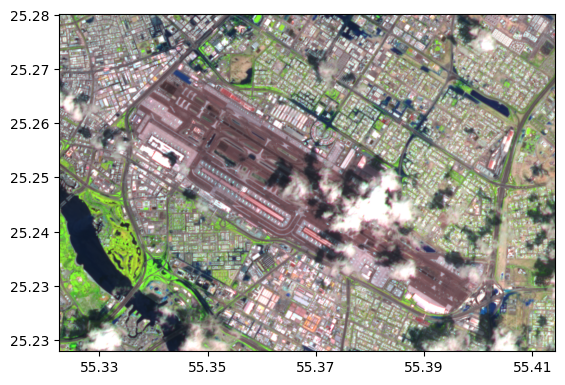

In [5]:
swirnirred = (img_local.isel({"band": [bands.index(b) for b in ["B11","B8","B4"]]}) / 4_500.).clip(0,1)

plot.show(swirnirred)

We will run the cloud detection model with all bands proposed in:

> Aybar, C., Ysuhuaylas, L., Loja, J., Gonzales, K., Herrera, F., Bautista, L., Yali, R., Flores, A., Diaz, L., Cuenca, N., Espinoza, W., Prudencio, F., Llactayo, V., Montero, D., Sudmanns, M., Tiede, D., Mateo-García, G., & Gómez-Chova, L. (2022). **CloudSEN12, a global dataset for semantic understanding of cloud and cloud shadow in Sentinel-2**. Scientific Data, 9(1), Article 1. https://doi.org/10.1038/s41597-022-01878-2

cloudsen12.pt:   0%|          | 0.00/80.0M [00:00<?, ?B/s]

<Axes: >

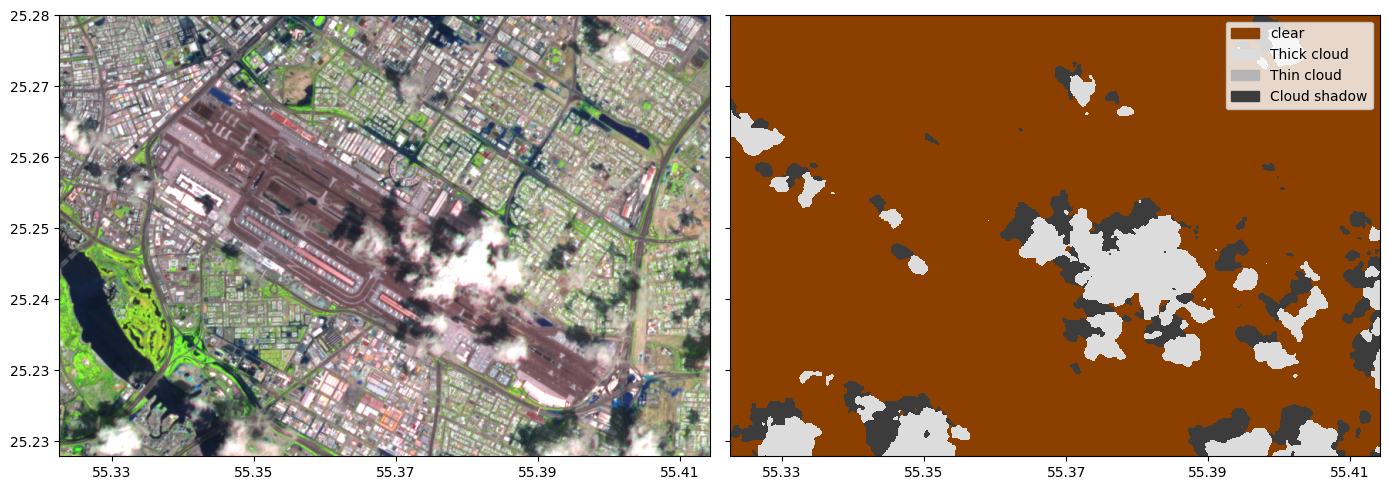

In [6]:
# load the model
model = cloudsen12.load_model_by_name(name="cloudsen12", weights_folder="cloudsen12_models")

# predict
cloudmask = model.predict(img_local/10_000)

#plot prediction
fig, ax = plt.subplots(1,2,figsize=(14,5),sharey=True, tight_layout=True)

plot.show(swirnirred,ax=ax[0])
cloudsen12.plot_cloudSEN12mask(cloudmask,ax=ax[1])

# fig.savefig("example_flood_dubai_2024.png")

### Flood segmentation

We will run the multioutput binary model described in the following article:

> E. Portalés-Julià, G. Mateo-García, C. Purcell, and L. Gómez-Chova [Global flood extent segmentation in optical satellite images](https://www.nature.com/articles/s41598-023-47595-7). _Scientific Reports 13, 20316_ (2023). DOI: 10.1038/s41598-023-47595-7.

>

For more information about running this model, we also refer to the following tutorial:
https://spaceml-org.github.io/ml4floods/content/ml4ops/HOWTO_postprocess_inference.html

First we download the flood model from hugging face

In [7]:
from huggingface_hub import hf_hub_download
# os.makedirs("models/WF2_unetv2_bgriswirs", exist_ok=True)
experiment_name = "WF2_unetv2_bgriswirs"
subfolder_local = f"models/{experiment_name}"
config_file = hf_hub_download(repo_id="isp-uv-es/ml4floods",subfolder=subfolder_local, filename="config.json",
                              local_dir=".", local_dir_use_symlinks=False)
model_file = hf_hub_download(repo_id="isp-uv-es/ml4floods",subfolder=subfolder_local, filename="model.pt",
                              local_dir=".", local_dir_use_symlinks=False)

models/WF2_unetv2_bgriswirs/config.json:   0%|          | 0.00/1.39k [00:00<?, ?B/s]

model.pt:   0%|          | 0.00/31.1M [00:00<?, ?B/s]

Using ml4floods functionalities we load the model and define a wrapper function around the inference function to predict using the values of geotensor


In [27]:
import numpy as np
import torch
from ml4floods.scripts.inference import load_inference_function, vectorize_outputv1
from ml4floods.models.model_setup import get_channel_configuration_bands


inference_function, config = load_inference_function(subfolder_local, device_name = 'cpu', max_tile_size=1024,
                                                     th_water=0.7, th_brightness=3500, 
                                                     distinguish_flood_traces=True)

channel_configuration = config['data_params']['channel_configuration']
channels  = get_channel_configuration_bands(channel_configuration, collection_name='S2')

def predict(input_tensor, channels = [1, 2, 3, 7, 11, 12] ):
    input_tensor = input_tensor.astype(np.float32)
    input_tensor = input_tensor[channels]
    torch_inputs = torch.tensor(np.nan_to_num(input_tensor))
    return inference_function(torch_inputs)

Loaded model weights: models/WF2_unetv2_bgriswirs/model.pt
Getting model inference function


In [28]:
# Predict using GeoTensor .values
prediction_postflood, prediction_postflood_cont  = predict(img_local.values, channels)

We combine the outputs of the flood segmentation model with CloudSEN12 outputs. This way we can mask clouds in the Sentinel-2 image as well as cloud shadows that can be easily mistaken by water in surfaces with high reflectivity. 

<Axes: >

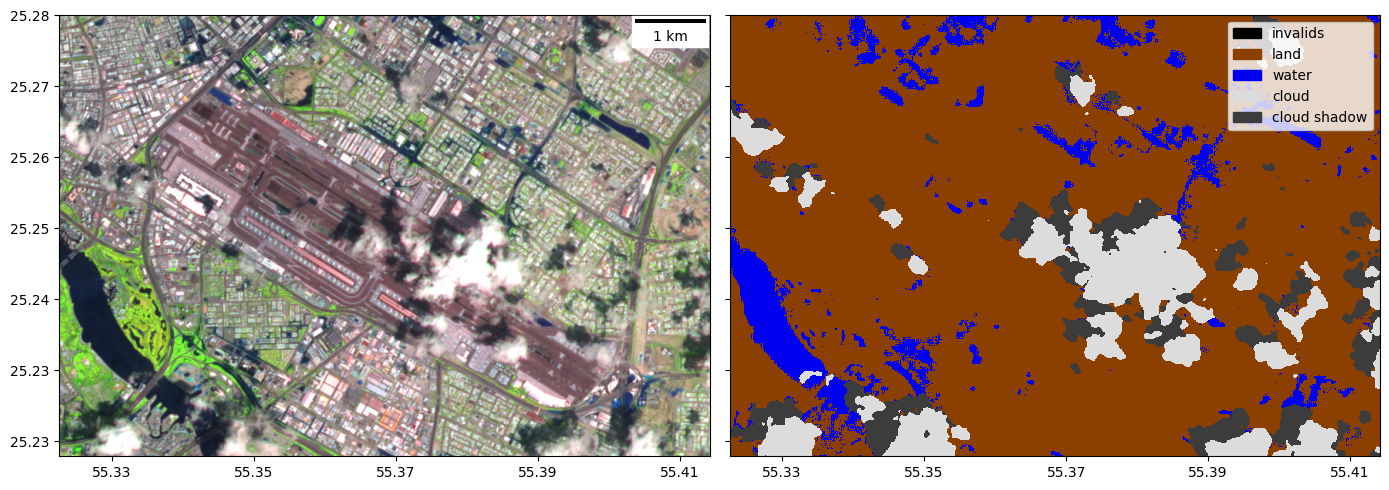

In [31]:
# from ml4floods.visualization.plot_utils import plot_segmentation_mask
from georeader.geotensor import GeoTensor

interpretation_array=["invalids", "land", "water", "cloud", "cloud shadow"]

COLORS_PRED = np.array([[0, 0, 0], # 0: invalid
                       [139, 64, 0], # 1: land
                       [0, 0, 240], # 2: water
                       [220, 220, 220], # 3: cloud
                       # [60, 85, 92], # 4: flood_trace
                       [60, 60, 60]], # 5: cloud_shadow
                    dtype=np.float32) / 255

prediction_tensor = torch.ones_like(prediction_postflood)

prediction_tensor[(prediction_postflood == 2)] = 2 # water is 2
# prediction_tensor[(prediction_postflood == 4)] = 4 # flood trace is 4
prediction_tensor[cloudmask.values == 1] = 3
prediction_tensor[cloudmask.values == 3] = 4

prediction_tensor = GeoTensor(prediction_tensor.cpu().numpy(), 
                              transform=swirnirred.transform, crs=swirnirred.crs,
                              fill_value_default=0)

fig, ax = plt.subplots(1,2,figsize=(14,5),sharey=True, tight_layout=True)

plot.show(swirnirred, ax=ax[0], add_scalebar=True)
plot.plot_segmentation_mask(prediction_tensor,
                            color_array=COLORS_PRED, 
                            interpretation_array=interpretation_array, legend = True)




## Licence
The `cloudsen12_models` package is published under a [GNU Lesser GPL v3 licence](https://www.gnu.org/licenses/lgpl-3.0.en.html)

The *CloudSEN12* database and all pre-trained models are released under a [Creative Commons non-commercial licence](https://creativecommons.org/licenses/by-nc/4.0/legalcode.txt). For using the models in comercial pipelines written consent by the authors must be provided.

The *WorldFloods* database and all pre-trained models are released under a [Creative Commons non-commercial licence](https://creativecommons.org/licenses/by-nc/4.0/legalcode.txt). For using the models in comercial pipelines written consent by the authors must be provided.

This notebook is released under a [Creative Commons non-commercial licence](https://creativecommons.org/licenses/by-nc/4.0/legalcode.txt).


 If you find this work useful please cite:
```
@article{aybar_cloudsen12_2022,
	title = {{CloudSEN12}, a global dataset for semantic understanding of cloud and cloud shadow in {Sentinel}-2},
	volume = {9},
	issn = {2052-4463},
	url = {https://www.nature.com/articles/s41597-022-01878-2},
	doi = {10.1038/s41597-022-01878-2},
	number = {1},
	urldate = {2023-01-02},
	journal = {Scientific Data},
	author = {Aybar, Cesar and Ysuhuaylas, Luis and Loja, Jhomira and Gonzales, Karen and Herrera, Fernando and Bautista, Lesly and Yali, Roy and Flores, Angie and Diaz, Lissette and Cuenca, Nicole and Espinoza, Wendy and Prudencio, Fernando and Llactayo, Valeria and Montero, David and Sudmanns, Martin and Tiede, Dirk and Mateo-García, Gonzalo and Gómez-Chova, Luis},
	month = dec,
	year = {2022},
	pages = {782},
}
```
```
@article{portales-julia_global_2023,
	title = {Global flood extent segmentation in optical satellite images},
	volume = {13},
	issn = {2045-2322},
	doi = {10.1038/s41598-023-47595-7},
	number = {1},
	urldate = {2023-11-30},
	journal = {Scientific Reports},
	author = {Portalés-Julià, Enrique and Mateo-García, Gonzalo and Purcell, Cormac and Gómez-Chova, Luis},
	month = nov,
	year = {2023},
	pages = {20316},
}
```

## Acknowledgments

This research has been supported by the DEEPCLOUD project (PID2019-109026RB-I00) funded by the Spanish Ministry of Science and Innovation (MCIN/AEI/10.13039/501100011033) and the European Union (NextGenerationEU).

<img width="300" title="DEEPCLOUD project (PID2019-109026RB-I00, University of Valencia) funded by MCIN/AEI/10.13039/501100011033." alt="DEEPCLOUD project (PID2019-109026RB-I00, University of Valencia) funded by MCIN/AEI/10.13039/501100011033." src="https://www.uv.es/chovago/logos/logoMICIN.jpg">